In [ ]:
!pip install ortools
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
import pandas as pd
import csv
import json
import time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString


import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import folium

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Education/PhD/Fleet Management Systems in Smart Cities (Cooperative Multi-Agent Reinforcement Learning for Traffic Flow Optimization)/notebooks/js_almaty_orders_ortools-experiment/20250212_prod_orders_202411_202412.csv', delimiter=';')
df.head()


,'order_item_create_date','status','process','actual_delivery_date','sender_city','sender_street','sender_building','sender_geo','receiver_city','receiver_street','receiver_building','receiver_geo'
0,2024-11-13 12:07:02.235,DELIVERED_ACCEPTED_MANAGER,ALSECO,2024-11-21 09:07:27.282,Алматы,'','',NaN,Алматы,Ришата и Муслима Абдуллиных,'45',"{""lat"":43.25821,""lon"":76.959402}"
1,2024-11-13 12:07:02.152,DELIVERED_ACCEPTED_MANAGER,ALSECO,2024-11-21 07:56:52.821,Алматы,'','',NaN,Алматы,Барибаева,'7',"{""lat"":43.264054,""lon"":76.962014}"
2,2024-11-13 12:07:05.845,DELIVERED_ACCEPTED_MANAGER,ALSECO,2024-11-22 15:09:03.920,Алматы,'','',NaN,Алматы,Курмангазы,'113',"{""lat"":43.243475,""lon"":76.92553}"
3,2024-11-13 12:07:03.194,DELIVERY_RETURNED_TO_SENDER,ALSECO,NaN,Алматы,'','',NaN,Алматы,Витебская,'33',"{""lat"":43.196112,""lon"":76.896063}"
4,2024-12-11 17:44:56.779,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2024-12-25 09:51:26.344,Алматы,Бекмаханова,'2/6',NaN,Алматы,Байзакова,'225',"{""lat"":43.246877,""lon"":76.911999}"


In [ ]:
df['\'receiver_geo\''].isnull().sum()

9

In [ ]:
df_geo = df[df['\'receiver_geo\''].notnull()]
df_geo.drop(df_geo[df_geo["'process'"] == 'ALSECO'].index, inplace=True)
df_geo.drop(df_geo[df_geo["'process'"] == 'INTER_CITY'].index, inplace=True)
df_geo.head()

<ipython-input-5-b8e7a6b4c7f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo.drop(df_geo[df_geo["'process'"] == 'ALSECO'].index, inplace=True)
<ipython-input-5-b8e7a6b4c7f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo.drop(df_geo[df_geo["'process'"] == 'INTER_CITY'].index, inplace=True)


,'order_item_create_date','status','process','actual_delivery_date','sender_city','sender_street','sender_building','sender_geo','receiver_city','receiver_street','receiver_building','receiver_geo'
4,2024-12-11 17:44:56.779,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2024-12-25 09:51:26.344,Алматы,Бекмаханова,'2/6',NaN,Алматы,Байзакова,'225',"{""lat"":43.246877,""lon"":76.911999}"
9,2024-12-10 07:06:44.514,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2024-12-19 11:35:03.624,Алматы,Земнухова,'35',"{""lat"":43.347734,""lon"":76.950303}",Алматы,Достык,'136',"{""lat"":43.235846,""lon"":76.959991}"
23,2024-12-05 16:16:20.728,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2024-12-06 06:25:26.648,Алматы,Бекмаханова,'2/6',NaN,Алматы,Емцова,'11',"{""lat"":43.259175,""lon"":76.861038}"
30,2024-12-11 05:53:13.235,READY_FOR_PICKUP,IN_CITY,NaN,Алматы,Достык,'134',NaN,Алматы,Ньютона,'1',"{""lat"":43.233413,""lon"":76.960056}"
37,2024-11-19 15:44:35.559,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2024-12-02 09:17:04.969,Алматы,Бекмаханова,'2/6',NaN,Алматы,Курмангазы,'104',"{""lat"":43.242997,""lon"":76.92632}"


In [ ]:
df_r_geo = df_geo["'receiver_geo'"]
df_r_geo.to_csv('geopoints.csv', index=None, header=None, quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")

In [ ]:
depot = ['{"lat":43.361718,"lon":76.954656}']
depot.extend(df_r_geo.tolist())

depot_df = pd.DataFrame(depot, columns=["'receiver_geo'"])
depot_df

,'receiver_geo'
0,"{""lat"":43.361718,""lon"":76.954656}"
1,"{""lat"":43.246877,""lon"":76.911999}"
2,"{""lat"":43.235846,""lon"":76.959991}"
3,"{""lat"":43.259175,""lon"":76.861038}"
4,"{""lat"":43.233413,""lon"":76.960056}"
5,"{""lat"":43.242997,""lon"":76.92632}"
6,"{""lat"":43.229524,""lon"":76.897341}"
7,"{""lat"":43.3461,""lon"":76.991076}"
8,"{""lat"":43.227606,""lon"":76.914183}"
9,"{""lat"":43.233535,""lon"":76.953925}"


In [ ]:
df_r_geo = depot_df

In [ ]:
lat_array = [json.loads(item)['lat'] for item in df_r_geo["'receiver_geo'"]]
lon_array = [json.loads(item)['lon'] for item in df_r_geo["'receiver_geo'"]]

lat_array = np.array(lat_array)
# reshaped_lat_arr = lat_array.reshape(-1, 1)

lon_array = np.array(lon_array)
# reshaped_lon_arr = lon_array.reshape(-1, 1)

In [ ]:
print(len(lon_array))

31


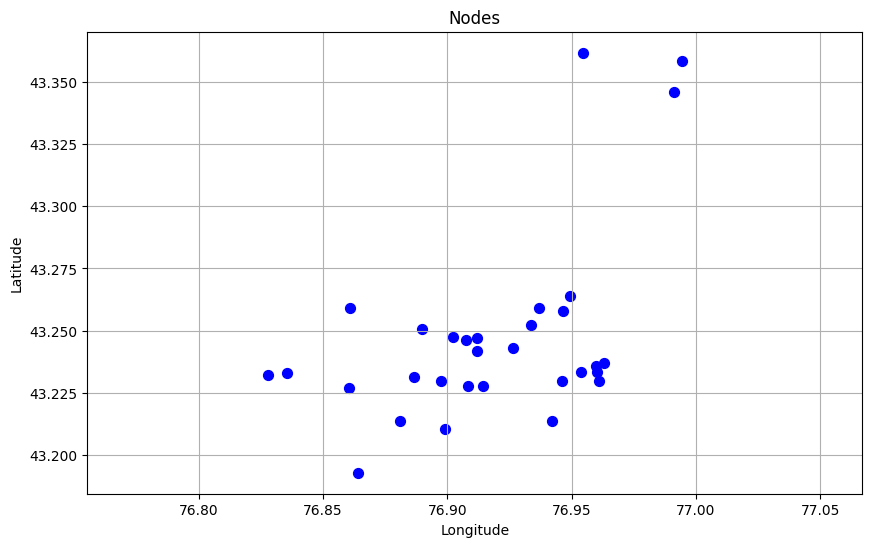

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(lon_array, lat_array, c='blue', s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Nodes")
plt.axis("equal")
plt.grid(True)
plt.show()

In [ ]:
def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        distance = distance_matrix[from_node][to_node]
        # print(f'Distance between {from_node} and {to_node} = {distance}')
        return int(distance)

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    route = []
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        route.append(manager.IndexToNode(index))
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    route.append(manager.IndexToNode(index))
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Objective: {route_distance}m\n"
    return route

In [ ]:
order_points = list(zip(lon_array, lat_array))
order_points

[(76.954656, 43.361718),
 (76.911999, 43.246877),
 (76.959991, 43.235846),
 (76.861038, 43.259175),
 (76.960056, 43.233413),
 (76.92632, 43.242997),
 (76.897341, 43.229524),
 (76.991076, 43.3461),
 (76.914183, 43.227606),
 (76.953925, 43.233535),
 (76.898933, 43.210566),
 (76.994197, 43.358453),
 (76.828009, 43.232008),
 (76.961071, 43.229671),
 (76.941946, 43.213632),
 (76.860583, 43.226727),
 (76.912133, 43.241633),
 (76.907423, 43.246157),
 (76.936734, 43.258967),
 (76.949415, 43.263855),
 (76.86393, 43.192842),
 (76.902423, 43.24729),
 (76.946655, 43.257699),
 (76.83557, 43.233137),
 (76.908264, 43.227871),
 (76.889945, 43.250561),
 (76.946078, 43.229771),
 (76.9337, 43.252106),
 (76.88116, 43.213729),
 (76.962823, 43.236901),
 (76.886416, 43.231467)]

In [ ]:
map_center = [order_points[0][1], order_points[0][0]]
mymap = folium.Map(location=map_center, zoom_start=11)

for node in order_points:
    folium.Marker([node[1], node[0]]).add_to(mymap)

# Save map to an HTML file
mymap.save("nodes_map.html")

# Display the map (if running in Jupyter notebook)
mymap


In [ ]:
with open("/content/drive/MyDrive/Education/PhD/Fleet Management Systems in Smart Cities (Cooperative Multi-Agent Reinforcement Learning for Traffic Flow Optimization)/notebooks/js_almaty_orders_ortools-experiment/orders_distance_matrix.json", "r") as f:
    data = json.load(f)

# Convert dictionary of dictionaries to a 2D distance matrix
# distance_matrix = [[data[str(i)][str(j)] for j in sorted(data[str(i)].keys())] for i in sorted(data.keys())]

distance_matrix = [[data[str(i)][str(j)] for j in data[str(i)].keys()] for i in data.keys()]

In [ ]:
# distance_matrix_np = np.array(distance_matrix)
# print(len(distance_matrix_np))
print(f"Количество точек: {len(distance_matrix)}")
for row in distance_matrix:
    print(f'{len(row)}:', row)

Количество точек: 31
31: [0, 15764.1, 17474.3, 15943.9, 17711.7, 16298.7, 18033.7, 5706.1, 18997.4, 17541.5, 19926.2, 7065.7, 20582.9, 18547.1, 21220.5, 19763, 17121.9, 16265.6, 13711.3, 12797.9, 22939.4, 16644.3, 14471.3, 19937.7, 19019.1, 15150.7, 17693.6, 14512.5, 19507.4, 17216.6, 17418.6]
31: [16252.5, 0, 5691.4, 6340.2, 5928.8, 1607, 3125.8, 16146.7, 3304.7, 5758.6, 5485.2, 17506.3, 8643.1, 6764.2, 8516.2, 6296.2, 1429.2, 619.9, 3394.6, 4985.9, 9003.2, 1172.9, 3859.5, 8526.7, 2865.2, 2330.8, 5913.7, 3066, 5571.2, 5433.7, 4035.4]
31: [17165.7, 5808.2, 0, 12032.8, 309.5, 4518.3, 6261.2, 15353.3, 5931.9, 943, 7262, 16712.9, 12638.5, 933.2, 6080, 10327.6, 5176, 6831.5, 5603.1, 4359.6, 11550.7, 6935.8, 3790.7, 11997.4, 5644, 8382.2, 2539.8, 4310.6, 8706.5, 449.3, 7170.7]
31: [15457.5, 6168.1, 11897.3, 0, 12134.7, 7812.9, 6496.7, 17102.4, 8477.1, 11964.5, 8389.2, 18462, 5786.6, 12970.1, 16418, 5104.6, 7635.1, 5825.5, 7212.5, 8978.8, 10149.6, 5356.1, 8789.1, 4913.2, 7730.9, 3613.7, 1107

In [ ]:
data = {}
data['locations'] = order_points
data["num_vehicles"] = 1
data["depot"] = 0

In [ ]:
# OR-Tools
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data["locations"]), data["num_vehicles"], data["depot"])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# distance_matrix = compute_euclidean_distance_matrix(center_points)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = ( routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC )
# search_parameters.time_limit.seconds = 30

NameError: name 'distance_callback' is not defined

In [ ]:
# Solve the problem.
start_time = time.time()
solution = routing.SolveWithParameters(search_parameters)
end_time = time.time()
print(f'Time to compute: {end_time - start_time}')


# Print solution on console.
solved_route = []
if solution:
  solved_route = print_solution(manager, routing, solution)

Time to compute: 0.03438162803649902
Objective: 99743
Route:
 0 -> 11 -> 7 -> 19 -> 22 -> 18 -> 27 -> 16 -> 21 -> 25 -> 17 -> 1 -> 5 -> 29 -> 2 -> 4 -> 13 -> 9 -> 26 -> 14 -> 10 -> 20 -> 28 -> 24 -> 8 -> 6 -> 30 -> 15 -> 23 -> 12 -> 3 -> 0



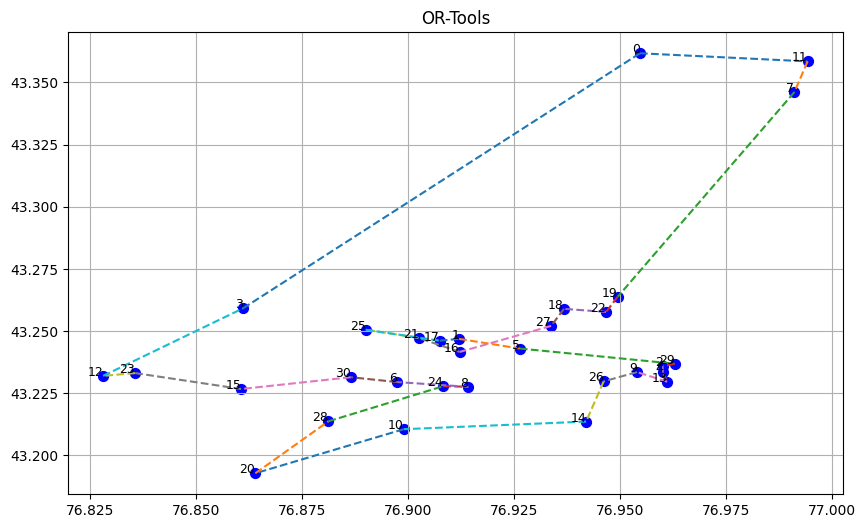

In [ ]:
if solved_route:
    plt.figure(figsize=(10, 6))
    plt.scatter(lon_array, lat_array, c='blue', s=50)

    for i in range(len(solved_route) - 1):
        from_node, to_node = solved_route[i], solved_route[i + 1]
        plt.plot([order_points[from_node][0], order_points[to_node][0]],
                [order_points[from_node][1], order_points[to_node][1]], '--')

    for i, (x, y) in enumerate(order_points):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

    plt.grid(True)
    plt.title("OR-Tools")
    plt.show()

In [ ]:

# Найдем центр карты по средним координатам
center_lat = sum(lat for _, lat in order_points) / len(order_points)
center_lon = sum(lon for lon, _ in order_points) / len(order_points)

# Создаем карту с центром
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Добавляем точки (узлы маршрута)
for i, (lon, lat) in enumerate(order_points):
    folium.Marker([lat, lon], popup=f"Point {i}", icon=folium.Icon(color="blue")).add_to(m)

# Добавляем линии маршрута
route_coords = [(order_points[node][1], order_points[node][0]) for node in solved_route]
folium.PolyLine(route_coords, color="red", weight=3, opacity=0.7).add_to(m)

# Показываем карту
m

# Shuffle all nodes

In [ ]:
with open("/content/drive/MyDrive/Education/PhD/Fleet Management Systems in Smart Cities (Cooperative Multi-Agent Reinforcement Learning for Traffic Flow Optimization)/notebooks/js_almaty_orders_ortools-experiment/distance_matrix_map.json", "r") as f:
    distance_map = json.load(f)


In [ ]:
# distance_map[f'{order_points[0][0]},{order_points[0][1]}']

def distance_map_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        from_node_key = f'{order_points[from_node][0]},{order_points[from_node][1]}'
        to_node = manager.IndexToNode(to_index)
        to_node_key = f'{order_points[to_node][0]},{order_points[to_node][1]}'
        print(f'Get [{from_node_key}] to [{to_node_key}]')
        return distance_map[from_node_key][to_node_key]

def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                dist = math.hypot((from_node[0] - to_node[0]), (from_node[1] - to_node[1]))
                # print(dist)
                distances[from_counter][to_counter] = int(dist*10000)
    return distances



manager = pywrapcp.RoutingIndexManager(len(data["locations"]), data["num_vehicles"], data["depot"])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

distance_matrix = compute_euclidean_distance_matrix(order_points)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = ( routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC )


# Solve the problem.
start_time = time.time
solution = routing.SolveWithParameters(search_parameters)
end_time = time.time()
print(f'Time to compute: {end_time - start_time}')

# Print solution on console.
solved_route = []
if solution:
  solved_route = print_solution(manager, routing, solution)

Objective: 6518
Route:
 0 -> 11 -> 7 -> 29 -> 2 -> 4 -> 13 -> 9 -> 26 -> 14 -> 8 -> 24 -> 6 -> 30 -> 10 -> 28 -> 20 -> 15 -> 23 -> 12 -> 3 -> 25 -> 21 -> 17 -> 1 -> 16 -> 5 -> 27 -> 18 -> 22 -> 19 -> 0



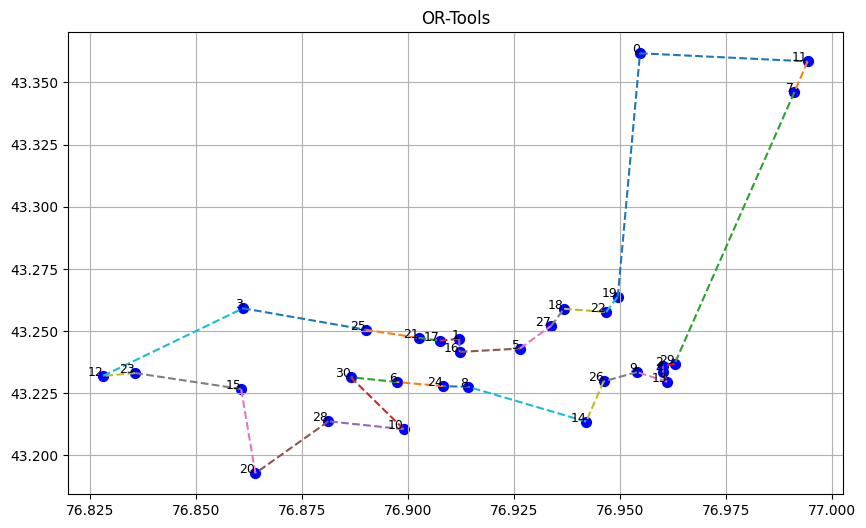

In [ ]:

if solved_route:
    plt.figure(figsize=(10, 6))
    plt.scatter(lon_array, lat_array, c='blue', s=50)

    for i in range(len(solved_route) - 1):
        from_node, to_node = solved_route[i], solved_route[i + 1]
        plt.plot([order_points[from_node][0], order_points[to_node][0]],
                [order_points[from_node][1], order_points[to_node][1]], '--')

    for i, (x, y) in enumerate(order_points):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

    plt.grid(True)
    plt.title("OR-Tools")
    plt.show()

In [ ]:
order_points

[(76.954656, 43.361718),
 (76.911999, 43.246877),
 (76.959991, 43.235846),
 (76.861038, 43.259175),
 (76.960056, 43.233413),
 (76.92632, 43.242997),
 (76.897341, 43.229524),
 (76.991076, 43.3461),
 (76.914183, 43.227606),
 (76.953925, 43.233535),
 (76.898933, 43.210566),
 (76.994197, 43.358453),
 (76.828009, 43.232008),
 (76.961071, 43.229671),
 (76.941946, 43.213632),
 (76.860583, 43.226727),
 (76.912133, 43.241633),
 (76.907423, 43.246157),
 (76.936734, 43.258967),
 (76.949415, 43.263855),
 (76.86393, 43.192842),
 (76.902423, 43.24729),
 (76.946655, 43.257699),
 (76.83557, 43.233137),
 (76.908264, 43.227871),
 (76.889945, 43.250561),
 (76.946078, 43.229771),
 (76.9337, 43.252106),
 (76.88116, 43.213729),
 (76.962823, 43.236901),
 (76.886416, 43.231467)]

In [ ]:
def find_closest(point, point_set):
    closest_point = None
    min_distance = float('inf')

    for p in point_set:
        if p == point:
            continue
        distance = math.hypot((point[0] - p[0]), (point[1] - p[1]))
        if distance < min_distance:
            min_distance = distance
            closest_point = p

    return closest_point, min_distance


sorted_order_points = sorted(order_points, key=lambda x: (-x[1], -x[0]))


ordered_points = []
cur_point = sorted_order_points[0]
sorted_order_points.remove(cur_point)
ordered_points.append(cur_point)

while len(sorted_order_points) > 0:
    cur_point, _ = find_closest(cur_point, sorted_order_points)
    sorted_order_points.remove(cur_point)
    ordered_points.append(cur_point)



ordered_points

[(76.954656, 43.361718),
 (76.991076, 43.3461),
 (76.994197, 43.358453),
 (76.949415, 43.263855),
 (76.946655, 43.257699),
 (76.936734, 43.258967),
 (76.9337, 43.252106),
 (76.92632, 43.242997),
 (76.912133, 43.241633),
 (76.911999, 43.246877),
 (76.907423, 43.246157),
 (76.902423, 43.24729),
 (76.889945, 43.250561),
 (76.886416, 43.231467),
 (76.897341, 43.229524),
 (76.908264, 43.227871),
 (76.914183, 43.227606),
 (76.898933, 43.210566),
 (76.88116, 43.213729),
 (76.860583, 43.226727),
 (76.83557, 43.233137),
 (76.828009, 43.232008),
 (76.861038, 43.259175),
 (76.86393, 43.192842),
 (76.941946, 43.213632),
 (76.946078, 43.229771),
 (76.953925, 43.233535),
 (76.960056, 43.233413),
 (76.959991, 43.235846),
 (76.962823, 43.236901),
 (76.961071, 43.229671)]

In [ ]:
custom_points = [
  (76.954656, 43.361718),
  (76.994197, 43.358453),
  (76.991076, 43.3461),
  (76.949415, 43.263855),
  (76.946655, 43.257699),

    (76.936734, 43.258967),
  (76.9337, 43.252106),
  (76.92632, 43.242997),

  (76.962823, 43.236901),
  (76.959991, 43.235846),
  (76.960056, 43.233413),
  (76.961071, 43.229671),
  (76.953925, 43.233535),
  (76.946078, 43.229771),
  (76.941946, 43.213632),

  (76.912133, 43.241633),
  (76.911999, 43.246877),
  (76.907423, 43.246157),
  (76.902423, 43.24729),
  (76.914183, 43.227606),
  (76.908264, 43.227871),
  (76.898933, 43.210566),
  (76.897341, 43.229524),
  (76.889945, 43.250561),
  (76.886416, 43.231467),
  (76.88116, 43.213729),
  (76.86393, 43.192842),
  (76.860583, 43.226727),
  (76.83557, 43.233137),
  (76.828009, 43.232008),
  (76.861038, 43.259175),
]


custom_route_indices = []
for point in custom_points:
  custom_route_indices.append(order_points.index(point))

manual_route_seq = ""
count = 0
while count < len(custom_route_indices):
  idx = custom_route_indices[count]
  manual_route_seq += (f" {idx} ->")
  count += 1

manual_route_seq += (f" 0")
print(manual_route_seq)


 0 -> 11 -> 7 -> 19 -> 22 -> 18 -> 27 -> 5 -> 29 -> 2 -> 4 -> 13 -> 9 -> 26 -> 14 -> 16 -> 1 -> 17 -> 21 -> 8 -> 24 -> 10 -> 6 -> 25 -> 30 -> 28 -> 20 -> 15 -> 23 -> 12 -> 3 -> 0


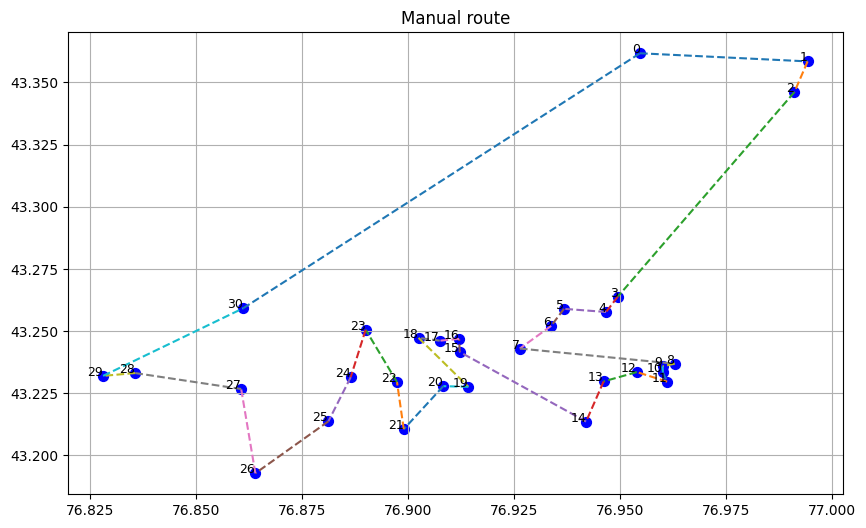

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter([t[0] for t in ordered_points], [t[1] for t in ordered_points], c='blue', s=50)

for i in range(len(custom_points) - 1):
  from_point, to_point = custom_points[i], custom_points[i + 1]
  plt.plot([from_point[0], to_point[0]],
                [from_point[1], to_point[1]], '--')

plt.plot([custom_points[len(custom_points)-1][0], custom_points[0][0]],
  [custom_points[len(custom_points)-1][1], custom_points[0][1]], '--')

for i, (x, y) in enumerate(custom_points):
  plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

plt.grid(True)
plt.title("Manual route")
plt.show()

In [ ]:

# custom_points
manual_center_lat = sum(lat for _, lat in custom_points) / len(custom_points)
manual_center_lon = sum(lon for lon, _ in custom_points) / len(custom_points)

# Создаем карту с центром
manual_m = folium.Map(location=[manual_center_lat, manual_center_lon], zoom_start=12)

# Добавляем точки (узлы маршрута)
for i, (lon, lat) in enumerate(custom_points):
    folium.Marker([lat, lon], popup=f"Point {i}", icon=folium.Icon(color="blue")).add_to(manual_m)

# Добавляем линии маршрута
route_coords = [(node[1], node[0]) for node in custom_points]
route_coords.append((custom_points[0][1], custom_points[0][0]))
folium.PolyLine(route_coords, color="blue", weight=3, opacity=0.7).add_to(manual_m)

# Показываем карту
manual_m

In [ ]:
manual_distance = 0

with open("/content/drive/MyDrive/Education/PhD/Fleet Management Systems in Smart Cities (Cooperative Multi-Agent Reinforcement Learning for Traffic Flow Optimization)/notebooks/js_almaty_orders_ortools-experiment/orders_distance_matrix.json", "r") as f:
    dist_json = json.load(f)

for i in range(len(custom_route_indices) - 1):
  manual_distance += dist_json[f'{custom_route_indices[i]}'][f'{custom_route_indices[i+1]}']

manual_distance += dist_json[f'{custom_route_indices[len(custom_route_indices) - 1]}'][f'{custom_route_indices[0]}']

# dist_json[f'{custom_route_indices[0]}'][f'{custom_route_indices[1]}']
math.ceil(manual_distance)


103982

[(76.954656, 43.361718),
 (76.911999, 43.246877),
 (76.959991, 43.235846),
 (76.861038, 43.259175),
 (76.960056, 43.233413),
 (76.92632, 43.242997),
 (76.897341, 43.229524),
 (76.991076, 43.3461),
 (76.914183, 43.227606),
 (76.953925, 43.233535),
 (76.898933, 43.210566),
 (76.994197, 43.358453),
 (76.828009, 43.232008),
 (76.961071, 43.229671),
 (76.941946, 43.213632),
 (76.860583, 43.226727),
 (76.912133, 43.241633),
 (76.907423, 43.246157),
 (76.936734, 43.258967),
 (76.949415, 43.263855),
 (76.86393, 43.192842),
 (76.902423, 43.24729),
 (76.946655, 43.257699),
 (76.83557, 43.233137),
 (76.908264, 43.227871),
 (76.889945, 43.250561),
 (76.946078, 43.229771),
 (76.9337, 43.252106),
 (76.88116, 43.213729),
 (76.962823, 43.236901),
 (76.886416, 43.231467)]

In [ ]:
# OR-Tools
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data["locations"]), data["num_vehicles"], data["depot"])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# distance_matrix = compute_euclidean_distance_matrix(center_points)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting solution metaheuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 30
search_parameters.log_search = True

# Solve the problem.
start_time = time.time()
tuned_solution = routing.SolveWithParameters(search_parameters)
end_time = time.time()
print(f'Time to compute: {end_time - start_time}')


# Print solution on console.
tuned_solved_route = []
if tuned_solution:
  tuned_solved_route = print_solution(manager, routing, tuned_solution)

Time to compute: 30.001509189605713
Objective: 95301
Route:
 0 -> 11 -> 7 -> 19 -> 18 -> 27 -> 22 -> 29 -> 2 -> 4 -> 13 -> 9 -> 26 -> 14 -> 10 -> 20 -> 12 -> 23 -> 15 -> 28 -> 30 -> 6 -> 24 -> 8 -> 5 -> 16 -> 1 -> 17 -> 21 -> 25 -> 3 -> 0



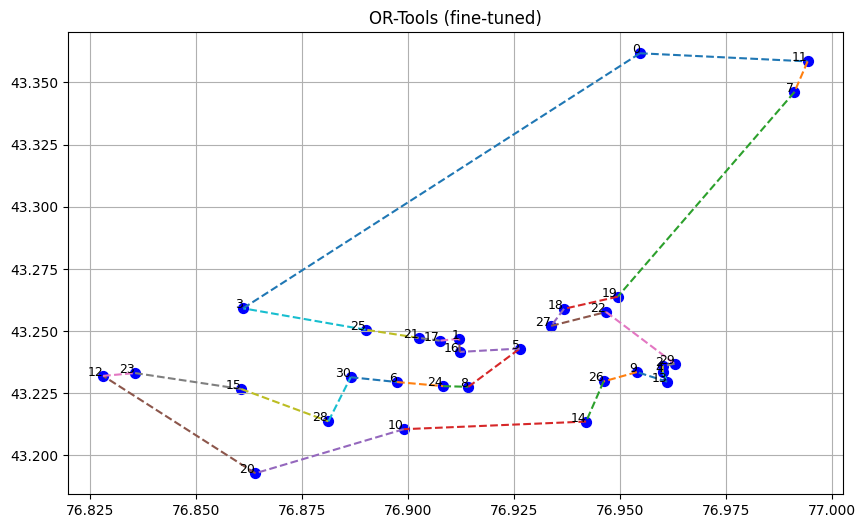

In [ ]:
if tuned_solved_route:
    plt.figure(figsize=(10, 6))
    plt.scatter(lon_array, lat_array, c='blue', s=50)

    for i in range(len(tuned_solved_route) - 1):
        from_node, to_node = tuned_solved_route[i], tuned_solved_route[i + 1]
        plt.plot([order_points[from_node][0], order_points[to_node][0]],
                [order_points[from_node][1], order_points[to_node][1]], '--')

    for i, (x, y) in enumerate(order_points):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

    plt.grid(True)
    plt.title("OR-Tools (fine-tuned)")
    plt.show()

In [ ]:
# OR-Tools
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data["locations"]), data["num_vehicles"], data["depot"])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting solution metaheuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 1
search_parameters.log_search = True

# Solve the problem.
start_time = time.time()
tuned_solution = routing.SolveWithParameters(search_parameters)
end_time = time.time()
print(f'Time to compute: {end_time - start_time}')


# Print solution on console.
tuned_solved_route = []
if tuned_solution:
  tuned_solved_route = print_solution(manager, routing, tuned_solution)

Time to compute: 1.0016374588012695
Objective: 95301
Route:
 0 -> 11 -> 7 -> 19 -> 18 -> 27 -> 22 -> 29 -> 2 -> 4 -> 13 -> 9 -> 26 -> 14 -> 10 -> 20 -> 12 -> 23 -> 15 -> 28 -> 30 -> 6 -> 24 -> 8 -> 5 -> 16 -> 1 -> 17 -> 21 -> 25 -> 3 -> 0



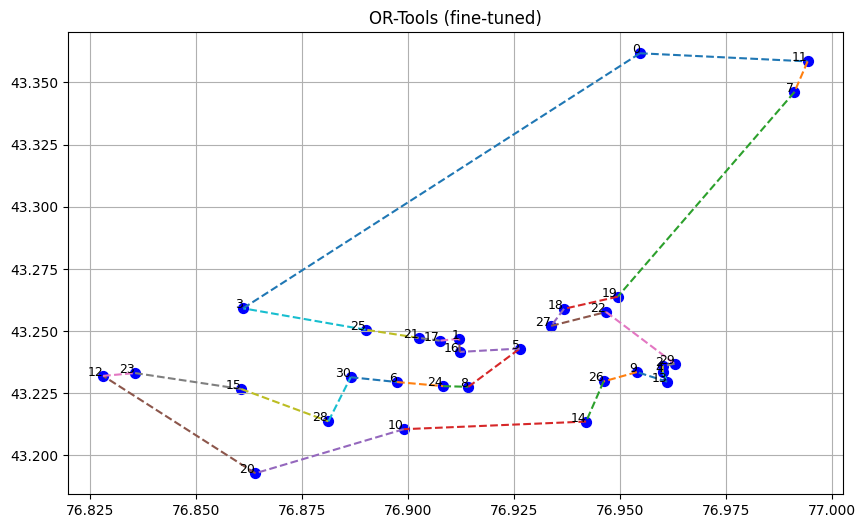

In [ ]:
if tuned_solved_route:
    plt.figure(figsize=(10, 6))
    plt.scatter(lon_array, lat_array, c='blue', s=50)

    for i in range(len(tuned_solved_route) - 1):
        from_node, to_node = tuned_solved_route[i], tuned_solved_route[i + 1]
        plt.plot([order_points[from_node][0], order_points[to_node][0]],
                [order_points[from_node][1], order_points[to_node][1]], '--')

    for i, (x, y) in enumerate(order_points):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

    plt.grid(True)
    plt.title("OR-Tools (fine-tuned)")
    plt.show()

In [ ]:
center_lat = sum(lat for _, lat in order_points) / len(order_points)
center_lon = sum(lon for lon, _ in order_points) / len(order_points)

tuned_m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Добавляем точки (узлы маршрута)
for i, (lon, lat) in enumerate(order_points):
    folium.Marker([lat, lon], popup=f"Point {i}", icon=folium.Icon(color="blue")).add_to(tuned_m)

# Добавляем линии маршрута
route_coords = [(order_points[node][1], order_points[node][0]) for node in tuned_solved_route]
folium.PolyLine(route_coords, color="green", weight=3, opacity=0.7).add_to(tuned_m)

# Показываем карту
tuned_m

# EXPERIMENT 2

In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/Education/PhD/Fleet Management Systems in Smart Cities (Cooperative Multi-Agent Reinforcement Learning for Traffic Flow Optimization)/notebooks/js_almaty_orders_ortools-experiment/prod_orders_202412_202501_202502172021.csv', delimiter=';')
df_2.head()


,'order_item_create_date','status','process','actual_delivery_date','sender_city','sender_street','sender_building','sender_geo','receiver_city','receiver_street','receiver_building','receiver_geo'
0,2024-12-23 05:26:54.596,READY_FOR_DELIVERY,IN_CITY,NaN,Алматы,Абылай хана,'53',"{""lat"":43.264037,""lon"":76.939834}",Алматы,Абая,'52 к2',"{""lat"":43.239772,""lon"":76.914201}"
1,2025-01-10 03:56:20.555,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2025-01-15 12:53:20.374,Алматы,Бекмаханова,'2/6',NaN,Алматы,Абылай хана,'3',"{""lat"":43.273048,""lon"":76.938169}"
2,2024-12-16 09:25:57.348,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2025-01-13 04:32:26.853,Алматы,Земнухова,'35',"{""lat"":43.347734,""lon"":76.950303}",Алматы,микрорайон Шугыла,'347/2',"{""lat"":43.206329,""lon"":76.788501}"
3,2024-12-23 05:39:25.290,READY_FOR_DELIVERY,IN_CITY,NaN,Алматы,Абылай хана,'53',"{""lat"":43.264037,""lon"":76.939834}",Алматы,Байтурсынова,'79',"{""lat"":43.247605,""lon"":76.926123}"
4,2025-01-10 04:36:14.714,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2025-01-15 12:53:13.360,Алматы,Абылай хана,'3',"{""lat"":43.273048,""lon"":76.938169}",Алматы,Бекмаханова,'2/6',NaN


In [ ]:
print('Null geolocations:', df_2['\'receiver_geo\''].isnull().sum())
print('Non-null geolocations:', df_2['\'receiver_geo\''].notnull().sum())

Null geolocations: 36
Non-null geolocations: 54


In [ ]:
df2_geo = df_2[df_2['\'receiver_geo\''].notnull()]
df2_geo.drop(df2_geo[df2_geo["'process'"] == 'ALSECO'].index, inplace=True)
df2_geo.drop(df2_geo[df2_geo["'process'"] == 'INTER_CITY'].index, inplace=True)
df2_geo.head()


<ipython-input-5-8b9361c40676>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_geo.drop(df2_geo[df2_geo["'process'"] == 'ALSECO'].index, inplace=True)
<ipython-input-5-8b9361c40676>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_geo.drop(df2_geo[df2_geo["'process'"] == 'INTER_CITY'].index, inplace=True)


,'order_item_create_date','status','process','actual_delivery_date','sender_city','sender_street','sender_building','sender_geo','receiver_city','receiver_street','receiver_building','receiver_geo'
0,2024-12-23 05:26:54.596,READY_FOR_DELIVERY,IN_CITY,NaN,Алматы,Абылай хана,'53',"{""lat"":43.264037,""lon"":76.939834}",Алматы,Абая,'52 к2',"{""lat"":43.239772,""lon"":76.914201}"
1,2025-01-10 03:56:20.555,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2025-01-15 12:53:20.374,Алматы,Бекмаханова,'2/6',NaN,Алматы,Абылай хана,'3',"{""lat"":43.273048,""lon"":76.938169}"
2,2024-12-16 09:25:57.348,DELIVERED_ACCEPTED_MANAGER,IN_CITY,2025-01-13 04:32:26.853,Алматы,Земнухова,'35',"{""lat"":43.347734,""lon"":76.950303}",Алматы,микрорайон Шугыла,'347/2',"{""lat"":43.206329,""lon"":76.788501}"
3,2024-12-23 05:39:25.290,READY_FOR_DELIVERY,IN_CITY,NaN,Алматы,Абылай хана,'53',"{""lat"":43.264037,""lon"":76.939834}",Алматы,Байтурсынова,'79',"{""lat"":43.247605,""lon"":76.926123}"
6,2024-12-20 06:56:30.249,READY_FOR_DELIVERY,IN_CITY,NaN,Алматы,Райымбека,'496а',"{""lat"":43.246597,""lon"":76.84332}",Алматы,Сейфуллина,'502',"{""lat"":43.250337,""lon"":76.934173}"


In [ ]:
df2_r_geo = df2_geo["'receiver_geo'"]
df2_r_geo.to_csv('geopoints_2.csv', index=None, header=None, quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")

In [ ]:
depot2 = ['{"lat":43.361718,"lon":76.954656}']
depot2.extend(df2_r_geo.tolist())

depot_df2 = pd.DataFrame(depot2, columns=["'receiver_geo'"])
depot_df2

,'receiver_geo'
0,"{""lat"":43.361718,""lon"":76.954656}"
1,"{""lat"":43.239772,""lon"":76.914201}"
2,"{""lat"":43.273048,""lon"":76.938169}"
3,"{""lat"":43.206329,""lon"":76.788501}"
4,"{""lat"":43.247605,""lon"":76.926123}"
5,"{""lat"":43.250337,""lon"":76.934173}"
6,"{""lat"":43.230264,""lon"":76.887863}"
7,"{""lat"":43.312275,""lon"":76.975153}"
8,"{""lat"":43.199334,""lon"":76.890841}"
9,"{""lat"":43.312275,""lon"":76.975153}"


In [ ]:


lat_array2 = [json.loads(item)['lat'] for item in depot_df2["'receiver_geo'"]]
lon_array2 = [json.loads(item)['lon'] for item in depot_df2["'receiver_geo'"]]

lat_array2 = np.array(lat_array2)
# reshaped_lat_arr = lat_array.reshape(-1, 1)

lon_array2 = np.array(lon_array2)

order_points2 = list(zip(lon_array2, lat_array2))
order_points2

[(76.954656, 43.361718),
 (76.914201, 43.239772),
 (76.938169, 43.273048),
 (76.788501, 43.206329),
 (76.926123, 43.247605),
 (76.934173, 43.250337),
 (76.887863, 43.230264),
 (76.975153, 43.312275),
 (76.890841, 43.199334),
 (76.975153, 43.312275),
 (76.932203, 43.266055),
 (76.903556, 43.193905),
 (76.946553, 43.229419),
 (76.907243, 43.20846),
 (76.96344, 43.228457),
 (76.947014, 43.240755),
 (76.892148, 43.243108),
 (76.818795, 43.223675),
 (76.881615, 43.236004),
 (76.947504, 43.252363),
 (76.949017, 43.272834),
 (76.879208, 43.200521),
 (76.874332, 43.271424),
 (76.950892, 43.26081),
 (76.903556, 43.193905),
 (76.918267, 43.243102),
 (76.974136, 43.246069),
 (76.979506, 43.257024),
 (76.885347, 43.230157),
 (76.906171, 43.25067),
 (76.955843, 43.2621),
 (76.95725, 43.209666),
 (76.883062, 43.320736),
 (76.9494, 43.257982),
 (76.891721, 43.21465),
 (76.962235, 43.22341),
 (76.896975, 43.202813),
 (76.960666, 43.250583),
 (76.914427, 43.226963),
 (76.911563, 43.197391),
 (76.948731

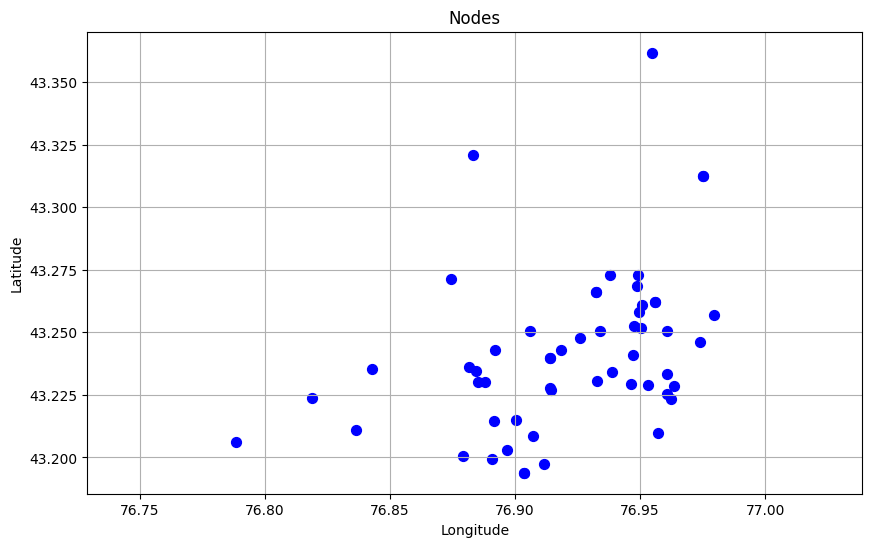

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(lon_array2, lat_array2, c='blue', s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Nodes")
plt.axis("equal")
plt.grid(True)
plt.show()


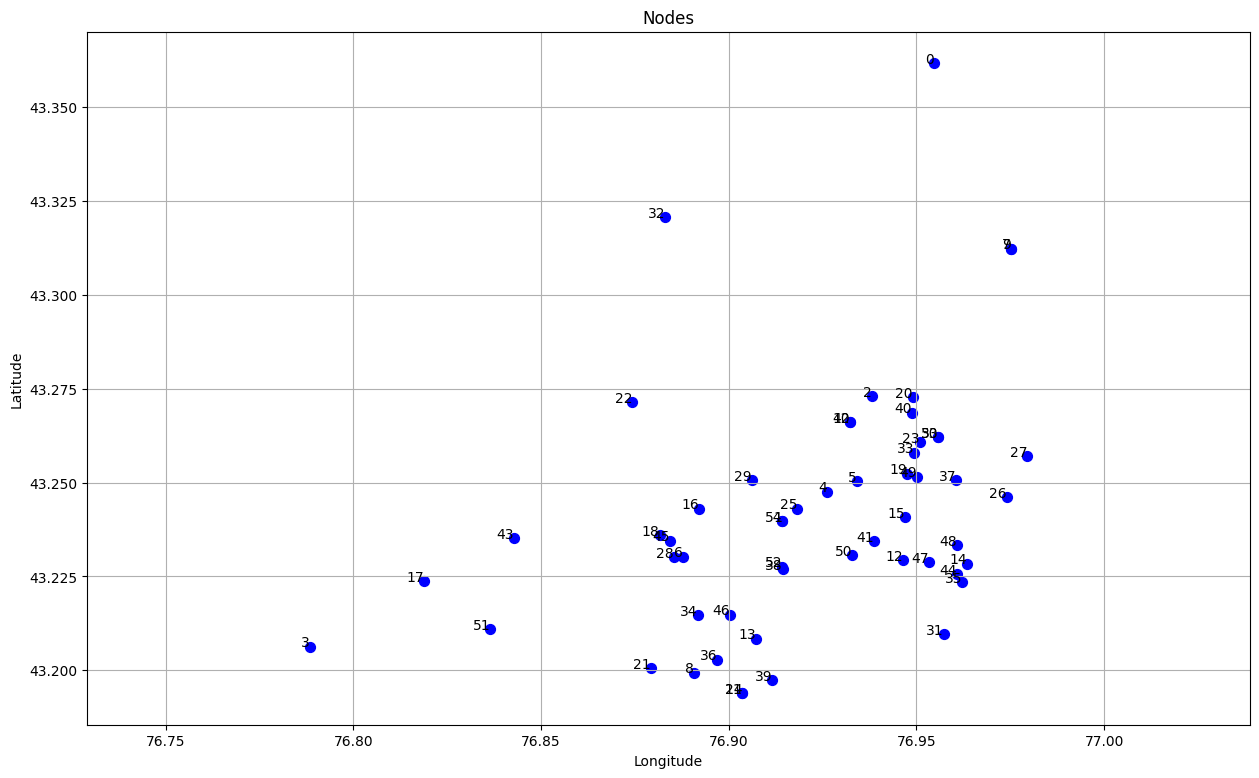

In [ ]:
plt.figure(figsize=(15, 9))
plt.scatter(lon_array2, lat_array2, c='blue', s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

for i, (x, y) in enumerate(order_points2):
  plt.text(x, y, str(i), fontsize=10, ha='right', color='black')

plt.title("Nodes")
plt.axis("equal")
plt.grid(True)
plt.show()

In [15]:
map_center2 = [order_points2[0][1], order_points2[0][0]]
mymap2 = folium.Map(location=map_center2, zoom_start=11)

for i, (x, y) in enumerate(order_points2):
  # if i not in (9, 7, 20, 2, 42, 10, 40, 53, 30, 23, 33, 27, 26, 37, 49, 19, 5, 15, 48, 14, 31, 35, 44, 47, 12, 41, 50, 38, 52, 54, 1, 25, 4, 29, 16, 18, 45, 28, 6, 34, 46, 13, 39, 24, 36, 8, 21, 11, 51, 3, 17, 43, 22, 32 ):
    folium.Marker([y, x],  popup=f"Point {i}").add_to(mymap2)

# Save map to an HTML file
mymap2.save("nodes_map2.html")

# Display the map (if running in Jupyter notebook)
mymap2


# Experiment 2. Manual Route


In [ ]:
manual_points = [(76.954656, 43.361718),
 (76.975153, 43.312275),
  (76.975153, 43.312275),
       (76.949017, 43.272834),
                 (76.938169, 43.273048),
                 (76.932203, 43.266055),
                 (76.932203, 43.266055),
                 (76.948731, 43.26861),
                 (76.955843, 43.2621),
                 (76.955843, 43.2621),
                 (76.950892, 43.26081),
                 (76.9494, 43.257982),
                 (76.979506, 43.257024),
                 (76.974136, 43.246069),
                 (76.960666, 43.250583),
                 (76.950188, 43.251586),
                 (76.947504, 43.252363),
                 (76.934173, 43.250337),
                 (76.947014, 43.240755),
                 (76.9607, 43.233302),
                 (76.96344, 43.228457),
                 (76.95725, 43.209666),
                 (76.962235, 43.22341),
                 (76.960875, 43.225556),
                 (76.953279, 43.228834),
                 (76.946553, 43.229419),
                 (76.938794, 43.23432),
                 (76.932957, 43.230727),
                 (76.914427, 43.226963),
                 (76.914183, 43.227606),
                 (76.914201, 43.239772),
                 (76.914201, 43.239772),
                  (76.918267, 43.243102),
                   (76.926123, 43.247605),
                 (76.906171, 43.25067),
                  (76.892148, 43.243108),
                 (76.881615, 43.236004),
                 (76.88438, 43.234514),
                 (76.885347, 43.230157),
                 (76.887863, 43.230264),
                 (76.891721, 43.21465),
                 (76.900375, 43.214836),
                 (76.907243, 43.20846),
                 (76.911563, 43.197391),
                 (76.903556, 43.193905),
                  (76.903556, 43.193905),
                 (76.896975, 43.202813),
                 (76.890841, 43.199334),
                 (76.879208, 43.200521),
                 (76.836527, 43.211019),
                 (76.788501, 43.206329),
                 (76.818795, 43.223675),
                 (76.842849, 43.235183),
                 (76.874332, 43.271424),
                 (76.883062, 43.320736),
                 ]

seen = []

manual_route_2_indices = []
for point in manual_points:
  idx = order_points2.index(point)
  if idx in seen:
    if idx == 7:
      idx = 9
    if idx == 10:
      idx = 42
    if idx == 30:
      idx = 53
    if idx == 1:
      idx = 54
    if idx == 11:
      idx = 24
  manual_route_2_indices.append(idx)
  seen.append(idx)

manual_route_2_seq = ""
count = 0
while count < len(manual_route_2_indices):
  idx = manual_route_2_indices[count]
  manual_route_2_seq += (f" {idx} ->")
  count += 1

manual_route_2_seq += (f" 0")
print(manual_route_2_seq)

 0 -> 7 -> 9 -> 20 -> 2 -> 10 -> 42 -> 40 -> 30 -> 53 -> 23 -> 33 -> 27 -> 26 -> 37 -> 49 -> 19 -> 5 -> 15 -> 48 -> 14 -> 31 -> 35 -> 44 -> 47 -> 12 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 4 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 39 -> 11 -> 24 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0


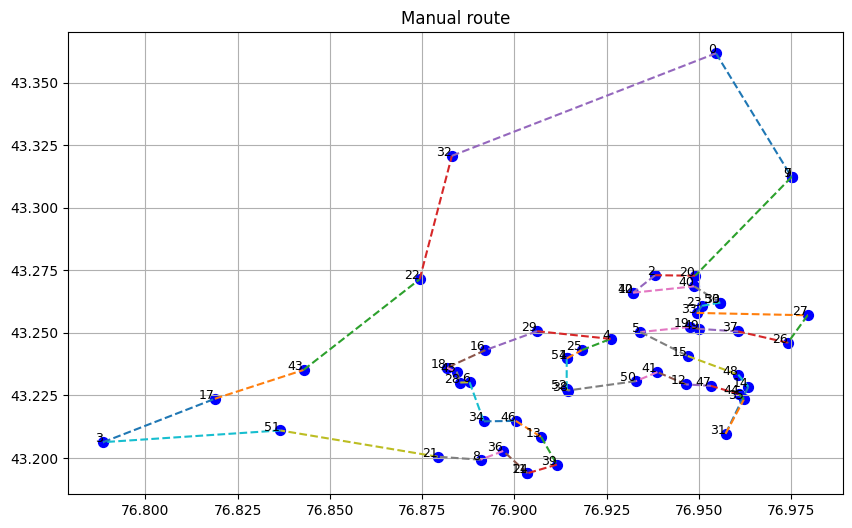

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter([t[0] for t in order_points2], [t[1] for t in order_points2], c='blue', s=50)

for i in range(len(manual_points) - 1):
  from_point, to_point = manual_points[i], manual_points[i + 1]
  plt.plot([from_point[0], to_point[0]],
                [from_point[1], to_point[1]], '--')

plt.plot([manual_points[len(manual_points)-1][0], manual_points[0][0]],
  [manual_points[len(manual_points)-1][1], manual_points[0][1]], '--')

for i, (x, y) in enumerate(order_points2):
  plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

plt.grid(True)
plt.title("Manual route")
plt.show()

In [ ]:
map_center2 = [order_points2[0][1], order_points2[0][0]]
mymap2 = folium.Map(location=map_center2, zoom_start=11)

for i, (x, y) in enumerate(order_points2):
  # if i not in (9, 7, 20, 2, 42, 10, 40, 53, 30, 23, 33, 27, 26, 37, 49, 19, 5, 15, 48, 14, 31, 35, 44, 47, 12, 41, 50, 38, 52, 54, 1, 25, 4, 29, 16, 18, 45, 28, 6, 34, 46, 13, 39, 24, 36, 8, 21, 11, 51, 3, 17, 43, 22, 32 ):
    folium.Marker([y, x],  popup=f"Point {i}").add_to(mymap2)

# Добавляем линии маршрута
route_coords = [(node[1], node[0]) for node in manual_points]
route_coords.append((manual_points[0][1], manual_points[0][0]))
folium.PolyLine(route_coords, color="blue", weight=3, opacity=0.7).add_to(mymap2)

# Save map to an HTML file
mymap2.save("nodes_map2.html")

# Display the map (if running in Jupyter notebook)
mymap2

In [ ]:
manual_distance2 = 0

with open("/content/drive/MyDrive/Education/PhD/Fleet Management Systems in Smart Cities (Cooperative Multi-Agent Reinforcement Learning for Traffic Flow Optimization)/notebooks/js_almaty_orders_ortools-experiment/distance_matrix_2_experiment.json", "r") as f:
    dist_json2 = json.load(f)

for i in range(len(manual_route_2_indices) - 1):
  manual_distance2 += dist_json2[f'{manual_route_2_indices[i]}'][f'{manual_route_2_indices[i+1]}']

manual_distance2 += dist_json2[f'{manual_route_2_indices[len(manual_route_2_indices) - 1]}'][f'{manual_route_2_indices[0]}']

# dist_json[f'{custom_route_indices[0]}'][f'{custom_route_indices[1]}']
math.ceil(manual_distance2)


127684

Experiment 2. **Manual route**:
* Total Distance: 127 684 (meters)
* Route: 0 -> 7 -> 9 -> 20 -> 2 -> 10 -> 42 -> 40 -> 30 -> 53 -> 23 -> 33 -> 27 -> 26 -> 37 -> 49 -> 19 -> 5 -> 15 -> 48 -> 14 -> 31 -> 35 -> 44 -> 47 -> 12 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 4 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 39 -> 11 -> 24 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0


In [ ]:
distance_matrix = [[dist_json2[str(i)][str(j)] for j in dist_json2[str(i)].keys()] for i in dist_json2.keys()]
# distance_matrix_np = np.array(distance_matrix)
# print(len(distance_matrix_np))
print(f"Количество точек: {len(distance_matrix)}")
for row in distance_matrix:
    print(f'{len(row)}:', row)

Количество точек: 55
55: [0, 17197.9, 13287.3, 25973.7, 15034.8, 14221.5, 17520, 8077.3, 20905.7, 8077.3, 12529.1, 22302, 17085.7, 20767.2, 17993.7, 15823.6, 16110.8, 23123.7, 17226.2, 15398.7, 11577, 21588.7, 13749.5, 13868.6, 22302, 16205.6, 16068.7, 15686, 17811.2, 15811.2, 13454.9, 19599.1, 9427, 14048.1, 19059.5, 18526.3, 20907.3, 14633.6, 18916.7, 22523.5, 12769.9, 16329, 12529.1, 19903, 18165.9, 17254.8, 19720.9, 18141, 17686.4, 14737.6, 16684.3, 22478.1, 18997.4, 13454.9, 17197.9]
55: [16908.1, 0, 6327, 12449.4, 1843.7, 2658.2, 3995.7, 12666.7, 6898.8, 12666.7, 4545, 7063.8, 4476.4, 5776.6, 5372.4, 3214.3, 3028, 10387.7, 3701.9, 3977.7, 7166.6, 7581.8, 8246.7, 5369.3, 7063.8, 939.2, 6175.1, 7335.8, 4286.9, 2374.8, 6011.7, 6055.6, 11362.6, 4920.6, 5052.6, 5905, 6430.4, 4759.5, 3153.3, 7285.4, 6100.4, 2791.4, 4545, 7260.8, 5544.6, 3730.4, 5031.1, 5519.7, 5065.1, 4336.3, 2629.1, 8953.8, 3234, 6011.7, 0]
55: [13170.7, 6445.7, 0, 18437.9, 4106.3, 3293.1, 9113.2, 8069.1, 12031.1, 806

In [ ]:
data = {}
data['locations'] = order_points2
data["num_vehicles"] = 1
data["depot"] = 0


In [ ]:
# OR-Tools
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data["locations"]), data["num_vehicles"], data["depot"])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# distance_matrix = compute_euclidean_distance_matrix(center_points)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = ( routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC )
# search_parameters.time_limit.seconds = 30

In [ ]:
# Solve the problem.
start_time = time.time()
solution = routing.SolveWithParameters(search_parameters)
end_time = time.time()
print(f'Time to compute: {end_time - start_time}')


# Print solution on console.
solved_route = []
if solution:
  solved_route = print_solution(manager, routing, solution)


Time to compute: 0.09481549263000488
Objective: 123823
Route:
 0 -> 9 -> 7 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 18 -> 45 -> 28 -> 6 -> 16 -> 29 -> 1 -> 54 -> 25 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 20 -> 40 -> 2 -> 10 -> 42 -> 22 -> 32 -> 0



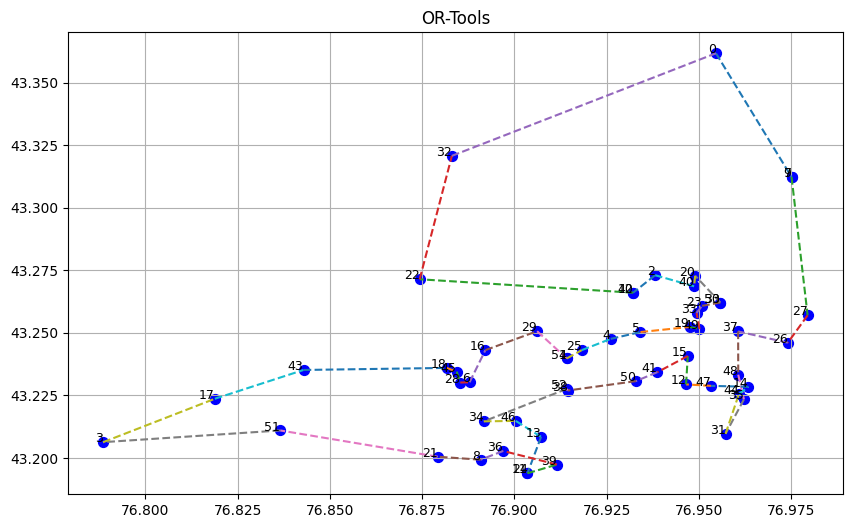

In [ ]:
if solved_route:
    plt.figure(figsize=(10, 6))
    plt.scatter(lon_array2, lat_array2, c='blue', s=50)

    for i in range(len(solved_route) - 1):
        from_node, to_node = solved_route[i], solved_route[i + 1]
        plt.plot([order_points2[from_node][0], order_points2[to_node][0]],
                [order_points2[from_node][1], order_points2[to_node][1]], '--')

    for i, (x, y) in enumerate(order_points2):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

    plt.grid(True)
    plt.title("OR-Tools")
    plt.show()

In [ ]:

# Найдем центр карты по средним координатам
center_lat = sum(lat for _, lat in order_points2) / len(order_points2)
center_lon = sum(lon for lon, _ in order_points2) / len(order_points2)

# Создаем карту с центром
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Добавляем точки (узлы маршрута)
for i, (lon, lat) in enumerate(order_points2):
    folium.Marker([lat, lon], popup=f"Point {i}", icon=folium.Icon(color="blue")).add_to(m)

# Добавляем линии маршрута
route_coords = [(order_points2[node][1], order_points2[node][0]) for node in solved_route]
folium.PolyLine(route_coords, color="red", weight=3, opacity=0.7).add_to(m)

# Показываем карту
m

Experiment 2. **OR-Tools route**:
* Total Distance: 123 823 (meters)
* Route: 0 -> 9 -> 7 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 18 -> 45 -> 28 -> 6 -> 16 -> 29 -> 1 -> 54 -> 25 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 20 -> 40 -> 2 -> 10 -> 42 -> 22 -> 32 -> 0



In [ ]:
# OR-Tools
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data["locations"]), data["num_vehicles"], data["depot"])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# distance_matrix = compute_euclidean_distance_matrix(center_points)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting solution metaheuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 33
search_parameters.log_search = True


In [ ]:
# Solve the problem.
start_time = time.time()
tuned_solution = routing.SolveWithParameters(search_parameters)
end_time = time.time()
print(f'Time to compute: {end_time - start_time}')


# Print solution on console.
tuned_solved_route = []
if tuned_solution:
  tuned_solved_route = print_solution(manager, routing, tuned_solution)


Time to compute: 33.00131106376648
Objective: 120854
Route:
 0 -> 7 -> 9 -> 20 -> 40 -> 2 -> 10 -> 42 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 30 -> 53 -> 27 -> 26 -> 37 -> 48 -> 14 -> 47 -> 44 -> 35 -> 31 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0



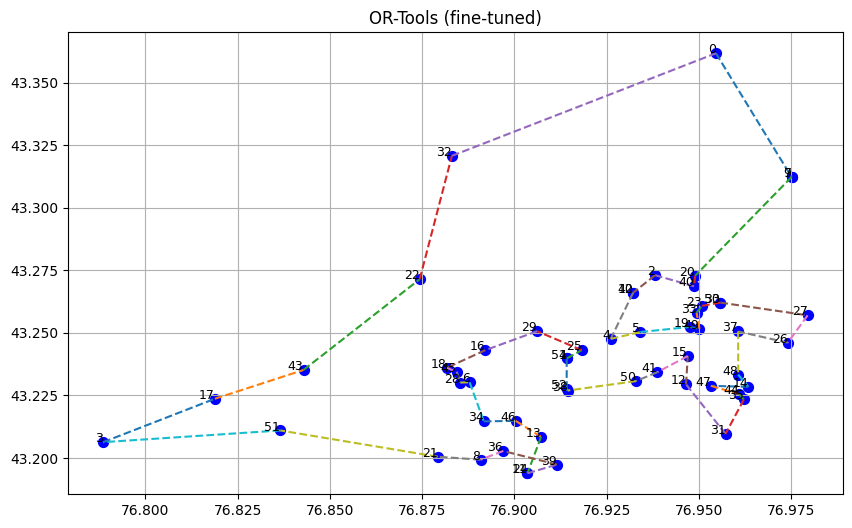

In [ ]:

if tuned_solved_route:
    plt.figure(figsize=(10, 6))
    plt.scatter(lon_array2, lat_array2, c='blue', s=50)

    for i in range(len(tuned_solved_route) - 1):
        from_node, to_node = tuned_solved_route[i], tuned_solved_route[i + 1]
        plt.plot([order_points2[from_node][0], order_points2[to_node][0]],
                [order_points2[from_node][1], order_points2[to_node][1]], '--')

    for i, (x, y) in enumerate(order_points2):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black')

    plt.grid(True)
    plt.title("OR-Tools (fine-tuned)")
    plt.show()

In [ ]:

center_lat = sum(lat for _, lat in order_points2) / len(order_points2)
center_lon = sum(lon for lon, _ in order_points2) / len(order_points2)

tuned_m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Добавляем точки (узлы маршрута)
for i, (lon, lat) in enumerate(order_points2):
    folium.Marker([lat, lon], popup=f"Point {i}", icon=folium.Icon(color="blue")).add_to(tuned_m)

# Добавляем линии маршрута
route_coords = [(order_points2[node][1], order_points2[node][0]) for node in tuned_solved_route]
folium.PolyLine(route_coords, color="green", weight=3, opacity=0.7).add_to(tuned_m)

# Показываем карту
tuned_m

##Experiment 2. OR-Tools (fine-tuned):##

### Run 1:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 60 seconds

**Results:**

Time to compute: 60.00195670127869

Objective: 120 854

Route:
 0 -> 7 -> 9 -> 20 -> 40 -> 2 -> 10 -> 42 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 30 -> 53 -> 27 -> 26 -> 37 -> 48 -> 14 -> 47 -> 44 -> 35 -> 31 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0

\\

### Run 2:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 30 seconds

**Results:**

Time to compute: 30.004950284957886

Objective: 120 854

Route:
 0 -> 7 -> 9 -> 20 -> 40 -> 2 -> 10 -> 42 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 30 -> 53 -> 27 -> 26 -> 37 -> 48 -> 14 -> 47 -> 44 -> 35 -> 31 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0


\\
### Run 3:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 20 seconds





**Results:**

Time to compute: 20.002293586730957

Objective: 121 618

Route:
 0 -> 9 -> 7 -> 20 -> 40 -> 2 -> 42 -> 10 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0


\\


### Run 4:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 10 seconds





**Results:**

Time to compute: 10.000125408172607

Objective: 121 618

Route:
 0 -> 9 -> 7 -> 20 -> 40 -> 2 -> 42 -> 10 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0

\\


### Run 5:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 5 seconds





**Results:**

Time to compute: 5.004415512084961

Objective: 121 618

Route:
 0 -> 9 -> 7 -> 20 -> 40 -> 2 -> 42 -> 10 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0

 \\


### Run 6:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 3 seconds





**Results:**

Time to compute: 3.0009751319885254

Objective: 121 618

Route:
 0 -> 9 -> 7 -> 20 -> 40 -> 2 -> 42 -> 10 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0

\\


### Run 7:###
**Params:**

Strategy: GUIDED_LOCAL_SEARCH

Time Limit: 1 seconds





**Results:**

Time to compute: 1.0010325908660889

Objective: 123 522

Route:
 0 -> 7 -> 9 -> 20 -> 2 -> 40 -> 33 -> 49 -> 19 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 18 -> 45 -> 28 -> 6 -> 16 -> 29 -> 1 -> 54 -> 25 -> 4 -> 5 -> 42 -> 10 -> 22 -> 32 -> 0


# Experiment 2. Results

**Manual route:**
* Total Distance: **127 684** (meters)
* Computation time: **n/a**
* Route: 0 -> 7 -> 9 -> 20 -> 2 -> 10 -> 42 -> 40 -> 30 -> 53 -> 23 -> 33 -> 27 -> 26 -> 37 -> 49 -> 19 -> 5 -> 15 -> 48 -> 14 -> 31 -> 35 -> 44 -> 47 -> 12 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 4 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 39 -> 11 -> 24 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0



**OR-Tools:**
* Total Distance: **123 823** (meters)
* Computation time: **~0.08** (seconds)
* Route: 0 -> 9 -> 7 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 18 -> 45 -> 28 -> 6 -> 16 -> 29 -> 1 -> 54 -> 25 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 20 -> 40 -> 2 -> 10 -> 42 -> 22 -> 32 -> 0


**OR-Tools (fine-tuned):**
* Best Results:
 * Total Distance: **120 854** (meters)
 * Computation time: **~30.00** (seconds)
 * Route: 0 -> 7 -> 9 -> 20 -> 40 -> 2 -> 10 -> 42 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 30 -> 53 -> 27 -> 26 -> 37 -> 48 -> 14 -> 47 -> 44 -> 35 -> 31 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0

\\
* Avg Results:
 * Total Distance: **121 618** (meters)
 * Computation time: **~3.00** (seconds)
 * Route: 0 -> 9 -> 7 -> 20 -> 40 -> 2 -> 42 -> 10 -> 4 -> 5 -> 19 -> 49 -> 33 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 1 -> 54 -> 25 -> 29 -> 16 -> 18 -> 45 -> 28 -> 6 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 22 -> 32 -> 0

 \\
* Worst Results:
 * Total Distance: **123 522** (meters)
 * Computation time: **~1.00** (seconds)
 * Route: 0 -> 7 -> 9 -> 20 -> 2 -> 40 -> 33 -> 49 -> 19 -> 23 -> 53 -> 30 -> 27 -> 26 -> 37 -> 48 -> 35 -> 31 -> 44 -> 14 -> 47 -> 12 -> 15 -> 41 -> 50 -> 38 -> 52 -> 34 -> 46 -> 13 -> 24 -> 11 -> 39 -> 36 -> 8 -> 21 -> 51 -> 3 -> 17 -> 43 -> 18 -> 45 -> 28 -> 6 -> 16 -> 29 -> 1 -> 54 -> 25 -> 4 -> 5 -> 42 -> 10 -> 22 -> 32 -> 0